# Generación Automatizada de Paletas de Colores a partir de Imágenes con Machine Learning

# Introducción
Este notebook se centra en la generación de paletas de colores a partir de imágenes utilizando técnicas de aprendizaje automático no supervisado. El objetivo es identificar los colores predominantes en una imagen y generar una paleta de colores representativa. Este proceso puede ser útil en diversas aplicaciones como diseño gráfico, análisis de tendencias de color, y más.

## Tabla de Contenidos
1. [Preparación de Datos](#preparacion_datos)
2. [Modelado](#Modelado)
3. [Descarte de Modelos de Clustering](#descarte-de-modelos-de-clustering)
4. [Construcción del Pipeline de Modelado](#construccion_pipeline)
5. [Aplicación del modelo K-Means a Imágenes Individuales](#aplicacion_modelo)
6. [Conclusiones del Proyecto](#conclusiones-del-proyecto)

# Importar las Librerias 

In [1]:
# Standard library imports
import os
import random
from itertools import product
from time import time

# Data handling library imports
import numpy as np
import pandas as pd

# Image processing library imports
import cv2

# Machine learning library imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             make_scorer, silhouette_score)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Fuzzy logic library imports
import skfuzzy as fuzz

# Gaussian Mixture Model import
from sklearn.mixture import GaussianMixture

# Visualization library imports
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns


<a id='preparacion_datos'></a>
# Preparación de Datos

En esta sección, cargaremos y prepararemos las imágenes para el análisis. Esto incluye la lectura de imágenes desde la carpeta Data y se dividen en carpetas por estilo artístico., normalización de los valores de los píxeles, y opcionalmente, aplanamiento de las imágenes para el procesamiento.
Para este proyecto se tomaron 156 imágenes en formato `.jpg` del repositorio [Wikiart](https://www.kaggle.com/datasets/steubk/wikiart) de Kaggle.

Número de imágenes en la carpeta: 156


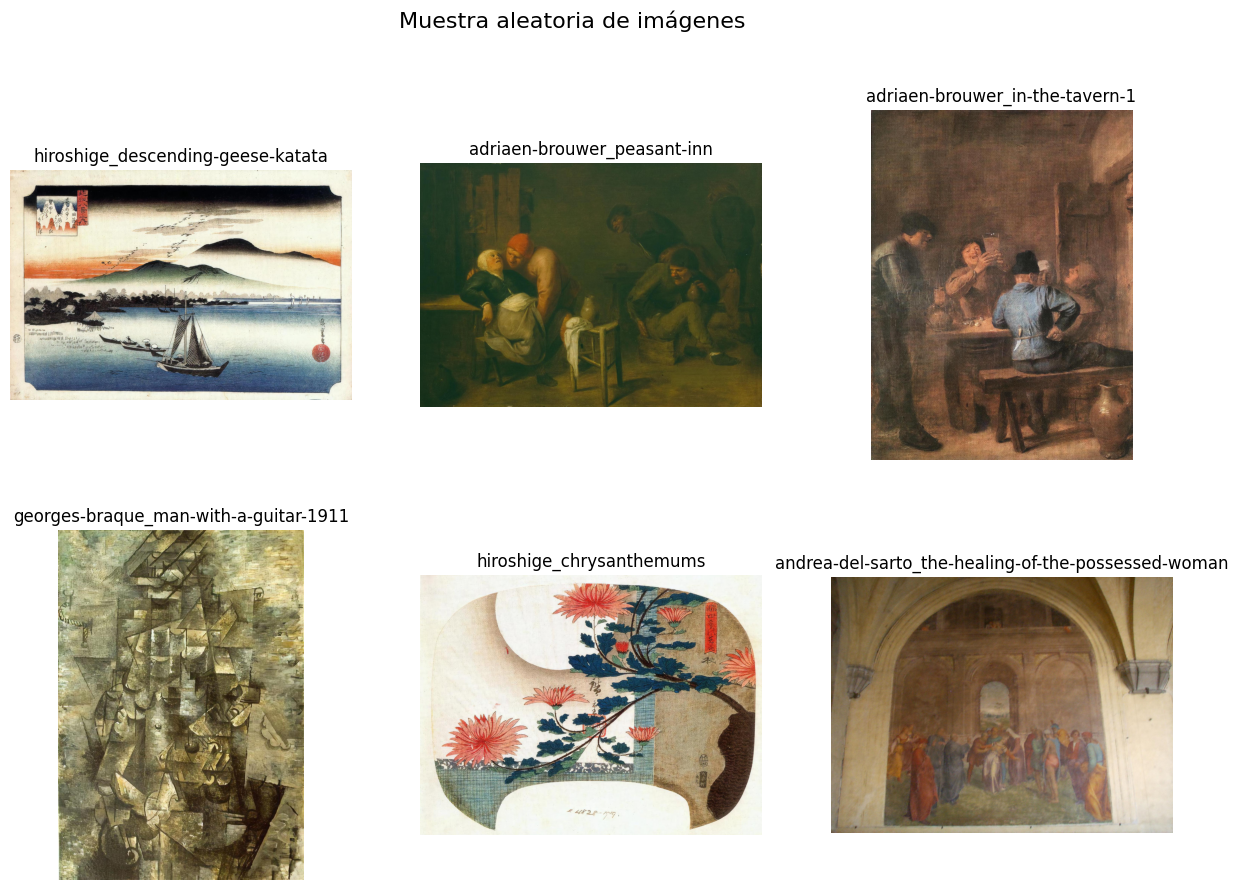

In [2]:
# Establecer una semilla para la reproducibilidad
np.random.seed(47)

# Definir la ruta de las imágenes
image_path = "./Data/"

def get_relative_paths(folder_path):
    """
    Obtiene los paths relativos de todas las imágenes en la carpeta folder_path con manejo de excepciones.

    Parametros:
    folder_path : str
        path de la carpeta que contiene las imágenes.
    
    Returns:
    files : list
        lista con los paths relativos de todas las imágenes en la carpeta folder_path.
    """
    files = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')
    try:
        for root, _, filenames in os.walk(folder_path):
            for filename in filenames:
                if filename.lower().endswith(valid_extensions):
                    path = os.path.join(root, filename).replace("\\", "/")
                    files.append(path)
    except Exception as e:
        print(f"Error al obtener paths: {e}")
    return files


def show_palette(cluster_centers,model_name,save_image=True):
    """
    Muestra la paleta de colores de la imagen.
    
    Parametros:
    cluster_centers : np.array
        Arreglo con los colores de los centros de los clusters normalizados.
    model_name : str
        Nombre del modelo para mostrar en el gráfico.
    """
    cluster_centers = cluster_centers * 255
    cluster_centers = cluster_centers.astype(np.uint8)
    plt.imshow([cluster_centers])
    plt.title('Paleta de colores - ' + model_name)
    plt.axis('off')
    # Adjust margins to remove blank space
    plt.margins(0)

    # Get rid of unnecessary padding
    plt.tight_layout()

    if save_image:
        save_path = "./Output/palette.png"

        if save_path:
            plt.savefig(save_path,bbox_inches='tight')
            plt.close()
            return None
        else:
            plt.show()
            plot_image = plt.imread(plt.savefig(None, format='png', bbox_inches='tight', pad_inches=0))
            plt.close()
            return plot_image

    else:
        
        return plt.show()

        
# Listar archivos utilizando la ruta definida
images_list = get_relative_paths(image_path)
print(f"Número de imágenes en la carpeta: {len(images_list)}")

# Seleccionar y mostrar 6 imágenes aleatorias
selected_images = np.random.choice(images_list, 6, replace=False)
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Muestra aleatoria de imágenes", fontsize=16)
for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    ax[i//3, i%3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i//3, i%3].title.set_text(os.path.basename(img_path).replace(".jpg", ""))
    ax[i//3, i%3].axis('off')
plt.show()


In [3]:
for img_path in images_list[:5]:  # Comprobar las primeras 5 rutas para diagnóstico
    print(f"Intentando leer la imagen en la ruta: {img_path}")
    image = cv2.imread(img_path)
    if image is None:
        print(f"No se pudo cargar la imagen en la ruta: {img_path}")
    else:
        print("Imagen cargada correctamente")


Intentando leer la imagen en la ruta: ./Data/Analytical_Cubism/albert-gleizes_acrobats-1916.jpg
Imagen cargada correctamente
Intentando leer la imagen en la ruta: ./Data/Analytical_Cubism/albert-gleizes_portrait-of-igor-stravinsky-1914.jpg
Imagen cargada correctamente
Intentando leer la imagen en la ruta: ./Data/Analytical_Cubism/albert-gleizes_woman-with-animals-1914.jpg
Imagen cargada correctamente
Intentando leer la imagen en la ruta: ./Data/Analytical_Cubism/georges-braque_a-girl(1).jpg
Imagen cargada correctamente
Intentando leer la imagen en la ruta: ./Data/Analytical_Cubism/georges-braque_bottle-and-fishes-1910.jpg
Imagen cargada correctamente


## Preprocesamiento
Para el preprocesamiento de las imágenes se utilizó la librería `PIL` para redimensionar las imágenes a un tamaño de 128x128 píxeles y convertirlas a RGB. Posteriormente, se "aplanan" las imágenes para convertirlas en un arreglo donde cada elemento está dado por pixel x canales de color, finalmente se normalizaron los valores de los píxeles dividiendo entre 255 para tener rangos de 0 a 1.

Ejemplo imagen preprocesada:
[[0.35686275 0.32941176 0.23137255]
 [0.41176471 0.38431373 0.30980392]
 [0.41176471 0.38039216 0.30980392]
 ...
 [0.4        0.40784314 0.36078431]
 [0.37647059 0.38431373 0.32941176]
 [0.35686275 0.36078431 0.30980392]]


(-0.5, 127.5, 127.5, -0.5)

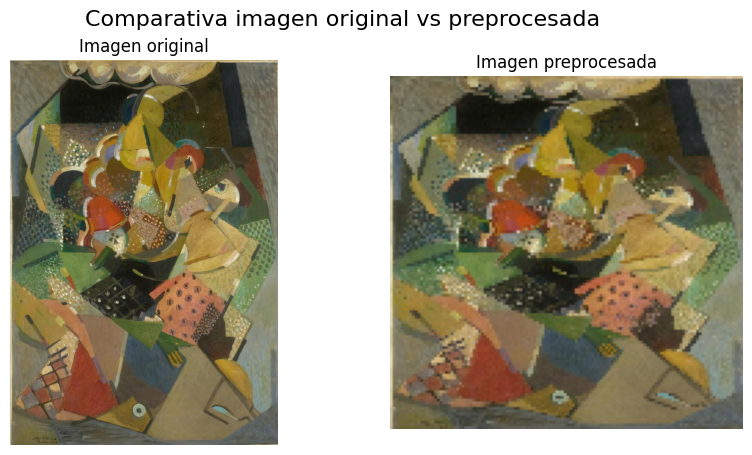

In [4]:
dimension_resize = 128

def preprocesar_imagen(image, dimension_resize=dimension_resize):
    # Convertir a RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Redimensionar
    image = cv2.resize(image, (dimension_resize, dimension_resize))
    # Flatten the image
    image = image.reshape((-1, 3))
    # normalize
    image = image / 255.0
    return image

print("Ejemplo imagen preprocesada:")
print(preprocesar_imagen(cv2.imread(images_list[0])))

# Comparativa imagen original vs preprocesada
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Comparativa imagen original vs preprocesada", fontsize=16)
img = cv2.imread(images_list[0])
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].title.set_text("Imagen original")
ax[0].axis('off')
# agregar un reshape dado que la imagen preprocesada es un vector
img = preprocesar_imagen(img).reshape((dimension_resize, dimension_resize, 3))
ax[1].imshow(img)
ax[1].title.set_text("Imagen preprocesada")
ax[1].axis('off')


# Modelado

En esta sección, nos enfocamos en el modelado de nuestro problema. El objetivo es identificar los colores predominantes en una colección de imágenes usando técnicas de clustering no supervisado. Analizaremos dos algoritmos comunes: KMeans y KMedoids, y determinaremos el número óptimo de clusters.

## Selección del Algoritmo

**KMeans** es eficiente y de fácil implementación, ideal para datos numéricos y clusters globulares. Su sensibilidad a los valores atípicos y la necesidad de definir el número de clusters a priori son factores a considerar.

**KMedoids** destaca por su robustez frente a outliers, utilizando puntos reales del conjunto de datos como centros de clusters. Aunque su costo computacional es mayor, es una opción sólida cuando la robustez es una prioridad.

## Determinación del Número Óptimo de Clusters

El método del codo nos ayudará a encontrar el número óptimo de clusters (k). Este enfoque consiste en variar k y observar la inercia, buscando el punto donde la reducción de la inercia se atenúa, lo que sugiere un buen balance entre número de clusters y compacidad.

## Ajuste del Modelo a los Datos

Prepararemos los datos extrayendo y normalizando las características de color de las imágenes. Luego, aplicaremos el método del codo para seleccionar un valor de k apropiado y ajustaremos el modelo de clustering a nuestros datos. Los centros de los clusters identificados se utilizarán para crear las paletas de colores.

## Ventajas y Desventajas de Algoritmos de Clustering

| Modelo de Clustering | Ventajas | Desventajas |
| -------------------- | -------- | ----------- |
| K-Means | - Eficiente y sencillo.<br>- Fácil de interpretar. | - Sensible a la inicialización.<br>- Puede converger a óptimos locales. |
| K-Medoids | - Robusto a outliers.<br>- Útil para datos no euclidianos. | - Computacionalmente costoso.<br>- Sensible a los medoids iniciales. |
| Mean Shift | - No requiere número de grupos predefinido.<br>- Captura formas irregulares. | - Computacionalmente intensivo.<br>- Puede converger a soluciones subóptimas. |
| DBSCAN | - Detección automática del número de grupos.<br>- Robusto al ruido y outliers. | - Requiere ajuste de parámetros.<br>- Problemas con grupos de densidad variable. |
| Agrupamiento Jerárquico | - Produce jerarquías visualizables.<br>- No necesita número de grupos predefinido. | - Costoso computacionalmente.<br>- No apto para datasets grandes. |
| GMM | - Enfoque probabilístico.<br>- Estima incertidumbre en asignaciones de grupo. | - Demanda computacionalmente.<br>- Sensible a la inicialización. |
| SOM | - Representación de baja dimensión para datos de alta dimensión.<br>- Preserva topología del espacio original. | - Parámetros críticos.<br>- Computacionalmente intensivo en entrenamiento. |
| Fuzzy C-Means | - Agrupamiento suave.<br>- Permite pertenencia a múltiples grupos. | - Requiere número de grupos y parámetro de difuminación.<br>- Más costoso que K-means. |


## Conclusión

El enfoque de modelado debe ser cuidadosamente seleccionado para equilibrar eficiencia computacional y precisión en la identificación de colores significativos dentro de las imágenes. La selección y optimización de estos modelos es crucial para la construcción de paletas de colores coherentes y visualmente atractivas.


<a id='Descarte-Modelos-Clustering'></a>
# Descarte de Modelos de Clustering

Dado que el objetivo es desarrollar un método que extraiga los tonos de una imagen para crear una paleta de colores entre 5 y 7 colores, es crucial seleccionar el algoritmo de clustering más adecuado. Aquí se consideran y descartan varios algoritmos basados en sus características y cómo se alinean con los requisitos del proyecto:

## Modelos Descartados

### K-Medoids
- **Razón del Descarte**: Este método es computacionalmente más lento que K-Means, ya que calcula todas las distancias entre puntos, lo cual es desventajoso dado el tamaño y la diversidad de las imágenes. Además, al utilizar colores reales de la imagen como prototipos, podría no crear paletas representativas debido a la variabilidad de colores en las obras de arte.

### Mean Shift
- **Razón del Descarte**: Aunque Mean Shift no requiere especificar el número de grupos a priori, es computacionalmente intensivo, especialmente para conjuntos de datos grandes. La necesidad de definir un radio de búsqueda añade una complejidad adicional no deseada.

### DBSCAN
- **Razón del Descarte**: DBSCAN es sensible a la elección de parámetros y puede no funcionar bien con la variabilidad de densidades presentes en imágenes artísticas, donde algunas áreas pueden estar saturadas de color mientras que otras son más uniformes.

### Agrupamiento Jerárquico Aglomerativo
- **Razón del Descarte**: Este método puede ser computacionalmente costoso y no es adecuado para el tamaño de nuestro conjunto de datos, que comprende imágenes de alta resolución.

### Mapas Auto-Organizativos (SOM)
- **Razón del Descarte**: SOM requiere un ajuste cuidadoso de parámetros y es intensivo en recursos durante la fase de entrenamiento, lo que no es ideal para nuestro caso de uso.

## Modelos Candidatos

### K-Means
- **Justificación de la Selección**: K-Means es adecuado para nuestro problema ya que permite especificar el número de colores (clusters) deseado, es eficiente computacionalmente y, al basarse en la media, proporciona un color representativo para cada cluster, lo cual es ideal para formar una paleta.

### Agrupamiento Fuzzy C-Means
- **Justificación de la Selección**: Similar a K-Means en que requiere un número predefinido de grupos, pero ofrece una asignación suave de los puntos de datos a los clusters. Aunque es más costoso que K-Means, puede ofrecer una visión más matizada de las paletas de colores.

### Modelos de Mezclas Gaussianas (GMM)
- **Justificación de la Selección**: Aunque es más intensivo computacionalmente, GMM proporciona un enfoque probabilístico que puede reconocer la superposición de colores, lo que puede ser útil para imágenes con una distribución de colores compleja.

### Visualización de la Distribución de Colores
Para la visualización, utilizaremos técnicas como PCA para reducir la dimensionalidad de los datos y t-SNE que es adecuada para la representación en dos dimensiones de la distribución de colores en nuestras paletas generadas&#8203;``【oaicite:0】``&#8203;.

## Comparación y Selección Final de Modelos
Compararemos los modelos de K-Means, Agrupamiento Fuzzy C-Means y GMM, con un número fijo de clusters y parámetros por defecto, para seleccionar el más adecuado basándonos en su desempeño y la calidad de las paletas de colores generadas.

## Métricas de Evaluación
- **Coeficiente de Calinski-Harabasz**: Para medir la calidad de los clusters formados.
- **Coeficiente de Davies-Bouldin**: Para evaluar la compacidad y la separación entre los clusters.


<a id='construccion_pipeline'></a>
# Construcción del Pipeline de Modelado

Para desarrollar un método que identifique los colores predominantes y genere una paleta representativa de una imagen, construiremos pipelines de procesamiento que integran tanto la preparación de datos como el modelado de clustering, siguiendo las directrices del proyecto&#8203;``【oaicite:1】``&#8203;.

El número de clusters para pruebas en cada algoritmo será de 7, en línea con las especificaciones del proyecto que sugieren que una paleta generada a partir de una imagen debería contener entre 5 y 7 colores&#8203;``【oaicite:0】``&#8203;.

A continuación, se definen los pipelines para K-Means, Agrupamiento Fuzzy C-Means y GMM, y se evalúan los resultados utilizando definidas previamente.

## Pipeline de K-Means

In [5]:
# número de clusters
n_clusters=7

# Pipeline con KMeans
pipeline_k_means = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', KMeans(n_clusters=n_clusters)) # Modelo base
])



## Pipeline con Fuzzy C-Means

In [6]:
# Definir el modelo como una clase
class FuzzyCMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=7, m=2, max_iter=1000, tol=0.005):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.tol = tol
    
    def fit(self, X, y=None):
        self.cluster_centers_, self.u, _, _, _, _, _ = fuzz.cluster.cmeans(X.T, self.n_clusters, self.m, error=self.tol, maxiter=self.max_iter, init=None)
        # las etiquetas serán el cluster con mayor pertenencia
        self.labels_ = np.argmax(self.u, axis=0)
        return self
    


pipeline_fuzzy = pipeline = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', FuzzyCMeansTransformer(n_clusters=n_clusters)) # Modelo base
])


## Pipeline con Modelo de Mezclas de Gaussianas

In [7]:


pipeline_gmm = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', GaussianMixture(n_components=n_clusters)) # Modelo base
])


## Métricas a evaluar

In [8]:
def metricas(X,labels):

    dict_metricas = {
        "calinski_harabasz":calinski_harabasz_score(X, labels), 
        "davies_bouldin":davies_bouldin_score(X, labels)}

    return dict_metricas

Se evalúa cada modelo con un set de 10 imágenes de prueba, se comparan las métricas y se decide sobre la media de las métricas y el tiempo de ejecución.

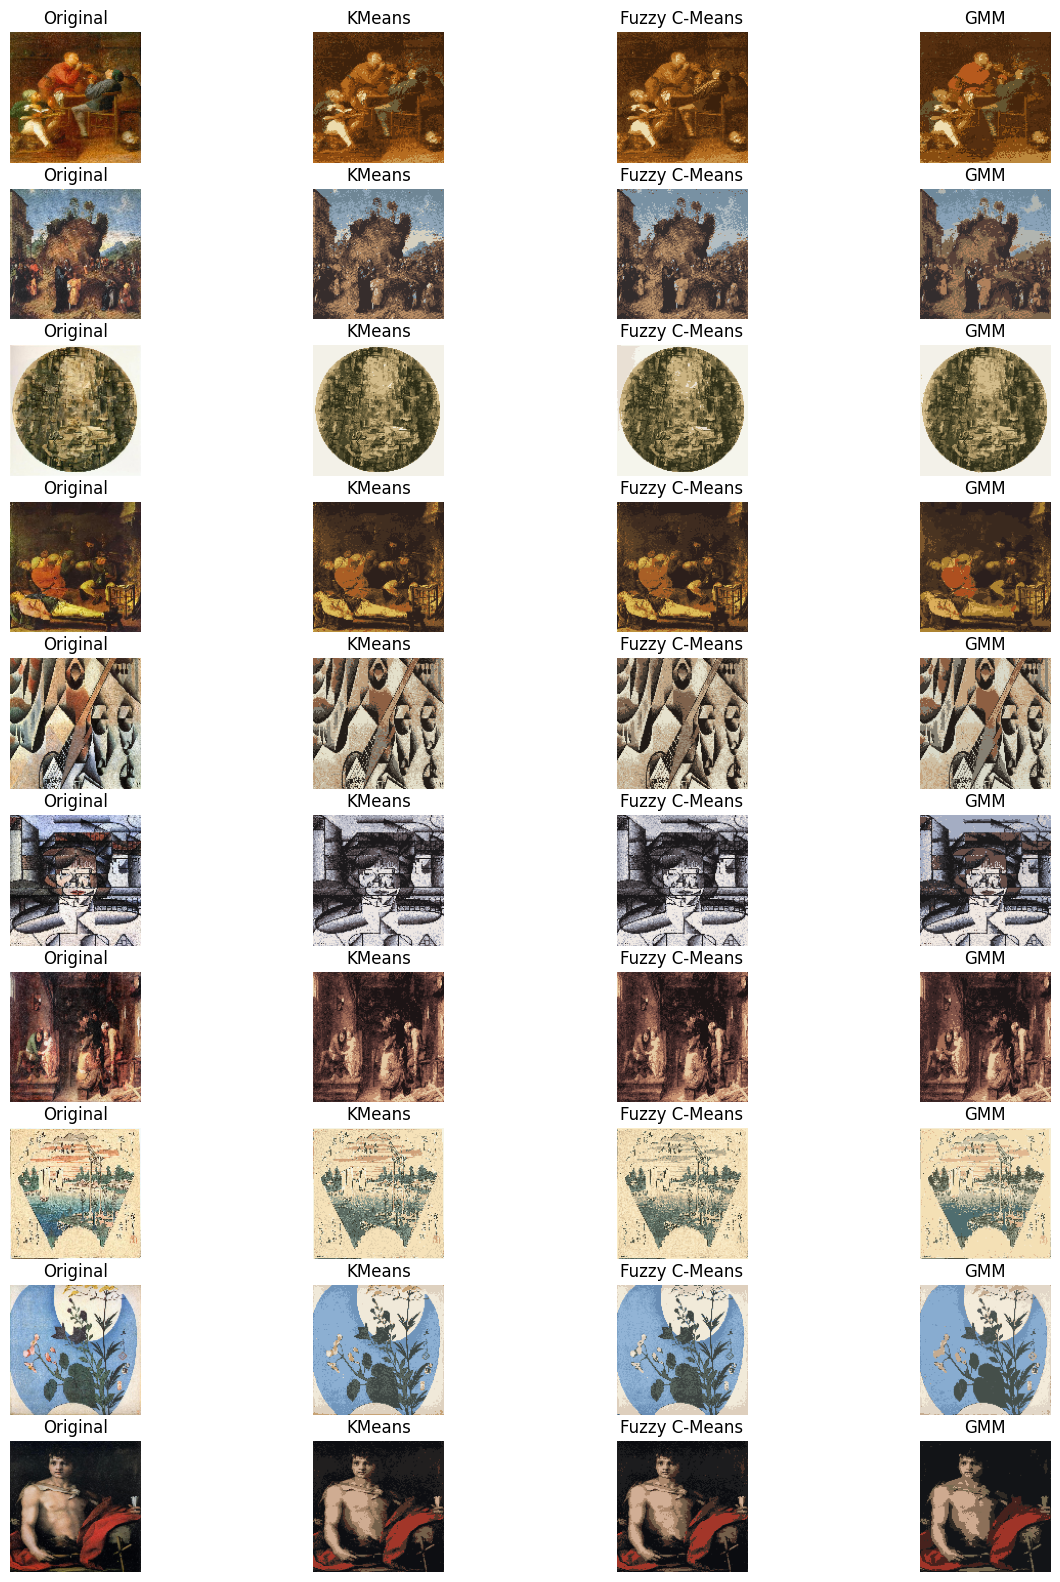

In [9]:
# Seleccionar 10 imágenes aleatorias para evaluar los modelos sin

test_images = random.sample(images_list, 10)

# Evaluar los modelos
modelo, imagen, calinski_harabasz, davies_bouldin, tiempo = [], [], [], [], []
def plot_original_image(ax, img, title='Original',dim = dimension_resize):
    ax.imshow(preprocesar_imagen(img).reshape(dim, dim, 3))
    ax.set_title(title)
    ax.axis('off')


def plot_segmented_image(ax, img, labels, cluster_centers, title, dim=dimension_resize):
    labels = labels.reshape((dim, dim))
    cluster_colors = np.array(cluster_centers)[labels.flatten()]

    segmented_image = cluster_colors.reshape((dim, dim, -1))
    
    # Create a ListedColormap from the cluster centers
    cmap = ListedColormap(cluster_centers)

    im = ax.imshow(segmented_image, cmap=cmap, vmin=0, vmax=len(cluster_centers)-1)
    ax.set_title(f"{title}")
    ax.axis('off')


fig, axs = plt.subplots(len(test_images), 4, figsize=(15, 20))

for i, image in enumerate(test_images):

    image_readed = cv2.imread(image)
    # dato transformado para generar métricas	
    X = pipeline.named_steps['preprocesar_imagen'].transform(image_readed)
    

    # Original
    plot_original_image(axs[i, 0], image_readed)


    # KMeans
    modelo.append("KMeans")
    imagen.append(image.split("/")[-1])

    ## Ajustar el modelo
    inicio = time()
    pipeline_k_means.fit(image_readed)
    fin = time()

    ## Obtener las etiquetas y los centros de los clusters
    labels = pipeline_k_means["cluster"].labels_
    cluster_centers = pipeline_k_means["cluster"].cluster_centers_

    
    ## Calcular métricas
    metricas_modelo = metricas(X,labels)
    calinski_harabasz.append(metricas_modelo["calinski_harabasz"])
    davies_bouldin.append(metricas_modelo["davies_bouldin"])
    tiempo.append(fin - inicio)

    ## Graficar
    plot_segmented_image(axs[i, 1], img, labels, cluster_centers, 'KMeans')


    # Fuzzy C-Means
    modelo.append("Fuzzy C-Means")
    imagen.append(image.split("/")[-1])

    ## Ajustar el modelo
    inicio = time()
    pipeline_fuzzy.fit(image_readed)
    fin = time()
    
    ## Obtener las etiquetas y los centros de los clusters
    labels = pipeline_fuzzy["cluster"].labels_
    cluster_centers = pipeline_fuzzy["cluster"].cluster_centers_

    ## Calcular métricas
    metricas_modelo = metricas(X,labels)
    calinski_harabasz.append(metricas_modelo["calinski_harabasz"])
    davies_bouldin.append(metricas_modelo["davies_bouldin"])
    tiempo.append(fin - inicio)

    ## Graficar
    plot_segmented_image(axs[i, 2], img, labels, cluster_centers, 'Fuzzy C-Means')


    # GMM
    modelo.append("GMM")
    imagen.append(image.split("/")[-1])
    
    ## Ajustar el modelo
    inicio = time()
    pipeline_gmm.fit(image_readed)
    fin = time()
    
    ## Obtener las etiquetas y los centros de los clusters
    labels = pipeline_gmm.predict(image_readed)
    cluster_centers = pipeline_gmm["cluster"].means_

    ## Calcular métricas
    metricas_modelo = metricas(X,labels)
    calinski_harabasz.append(metricas_modelo["calinski_harabasz"])
    davies_bouldin.append(metricas_modelo["davies_bouldin"])
    tiempo.append(fin - inicio)

    ## Graficar
    plot_segmented_image(axs[i, 3], img, labels, cluster_centers, 'GMM')



# Crear un DataFrame con los resultados

resultados_modelos = pd.DataFrame({
    "modelo": modelo,
    "imagen": imagen,
    "calinski_harabasz": calinski_harabasz,
    "davies_bouldin": davies_bouldin,
    "tiempo": tiempo
})



## Análisis de Rendimiento de Modelos de Clustering

Tras una evaluación visual de las paletas generadas por diferentes modelos de clustering, observamos que mientras KMeans y Fuzzy C-Means proporcionan resultados similares con una segmentación de colores claramente definida, el Modelo de Mezclas Gaussianas (GMM) parece tener dificultades para diferenciar entre tonalidades sutiles, resultando en una paleta de colores menos precisa.

Esta observación visual nos indica que, aunque GMM es teóricamente capaz de modelar la superposición de clusters y tiene un enfoque probabilístico sofisticado, no necesariamente se traduce en una mejor segmentación de colores para nuestro conjunto de datos específico. Esto puede deberse a la naturaleza de las imágenes artísticas que estamos analizando, las cuales pueden tener gradientes y sombras que un modelo como GMM podría malinterpretar como clusters separados.

### Evaluación Cuantitativa

Para confirmar nuestras observaciones visuales, procedemos a evaluar cuantitativamente el rendimiento de los modelos utilizando las métricas de Calinski-Harabasz y Davies-Bouldin:

- **Coeficiente de Calinski-Harabasz**: Una puntuación más alta en esta métrica sugiere clusters bien definidos y separados. KMeans y Fuzzy C-Means tienden a desempeñarse bien en este aspecto debido a su naturaleza determinística y al enfoque en la optimización de la varianza intra-cluster.

- **Coeficiente de Davies-Bouldin**: En contraste, un valor más bajo en esta métrica indica una mejor separación de clusters. La tendencia de GMM a mezclar colores similares puede resultar en una puntuación más alta, lo que implica una peor separación de clusters.

### Conclusión Preliminar

Nuestro análisis preliminar sugiere que, para la tarea de extraer paletas de colores de obras de arte, los modelos que simplifican la estructura de los datos (como KMeans y Fuzzy C-Means) pueden ser más adecuados que un modelo que busca capturar complejidades que no son beneficiosas para la tarea en cuestión. Se necesitarán más investigaciones y posiblemente ajustes en la configuración del modelo, especialmente para GMM, para mejorar su capacidad de distinguir colores de manera efectiva en nuestro contexto específico.

En la siguiente fase, consolidaremos estos hallazgos con una evaluación estadística más profunda y consideraremos ajustes de hiperparámetros para optimizar el rendimiento de cada modelo.


In [10]:
resultados_modelos

modelo                                             imagen  \
0          KMeans  adriaen-brouwer_the-smokers-or-the-peasants-of...   
1   Fuzzy C-Means  adriaen-brouwer_the-smokers-or-the-peasants-of...   
2             GMM  adriaen-brouwer_the-smokers-or-the-peasants-of...   
3          KMeans           andrea-del-sarto_stories-of-joseph-1.jpg   
4   Fuzzy C-Means           andrea-del-sarto_stories-of-joseph-1.jpg   
5             GMM           andrea-del-sarto_stories-of-joseph-1.jpg   
6          KMeans          georges-braque_man-with-a-violin-1912.jpg   
7   Fuzzy C-Means          georges-braque_man-with-a-violin-1912.jpg   
8             GMM          georges-braque_man-with-a-violin-1912.jpg   
9          KMeans               adriaen-brouwer_scene-at-the-inn.jpg   
10  Fuzzy C-Means               adriaen-brouwer_scene-at-the-inn.jpg   
11            GMM               adriaen-brouwer_scene-at-the-inn.jpg   
12         KMeans  juan-gris_guitar-and-glasses-banjo-and-glasses...   
13  Fuzzy C-Means  juan-gris_guitar-and-glasses-banjo-and-glasses...   
14            GMM  juan-gris_guitar-and-glasses-banjo-and-glasses...   
15         KMeans     juan-gris_portrait-of-germaine-raynal-1912.jpg   
16  Fuzzy C-Means     juan-gris_portrait-of-germaine-raynal-1912.jpg   
17            GMM     juan-gris_portrait-of-germaine-raynal-1912.jpg   
18         KMeans                   adriaen-brouwer_tavern-scene.jpg   
19  Fuzzy C-Means                   adriaen-brouwer_tavern-scene.jpg   
20            GMM                   adriaen-brouwer_tavern-scene.jpg   
21         KMeans      hiroshige_alighting-geese-at-massaki-1825.jpg   
22  Fuzzy C-Means      hiroshige_alighting-geese-at-massaki-1825.jpg   
23            GMM      hiroshige_alighting-geese-at-massaki-1825.jpg   
24         KMeans  hiroshige_autumn-flowers-in-front-of-full-moon...   
25  Fuzzy C-Means  hiroshige_autumn-flowers-in-front-of-full-moon...   
26            GMM  hiroshige_autumn-flowers-in-front-of-full-moon...   
27         KMeans         andrea-del-sarto_st-john-the-baptist-1.jpg   
28  Fuzzy C-Means         andrea-del-sarto_st-john-the-baptist-1.jpg   
29            GMM         andrea-del-sarto_st-john-the-baptist-1.jpg   

    calinski_harabasz  davies_bouldin    tiempo  
0        22210.620074        0.851479  0.518899  
1        20740.317079        0.991061  0.852192  
2        13296.483610        1.209982  0.272107  
3        33455.802350        0.733679  0.012000  
4        29421.118031        0.822916  0.561510  
5        14591.269356        1.129376  0.220286  
6       167965.859294        0.596782  0.011979  
7       153683.419015        0.612926  0.734374  
8       141062.212361        0.641646  0.110492  
9        36433.198913        0.928038  0.011989  
10       36339.470055        0.920014  0.749340  
11       17699.987345        1.164127  0.568760  
12       52333.385752        0.851757  0.010091  
13       51492.261430        0.886548  1.124264  
14       35366.327064        1.014471  0.209983  
15       99030.851685        0.756443  0.011989  
16       98671.191991        0.750580  1.086975  
17       39241.891394        1.194562  0.252582  
18       53141.206723        0.744832  0.019996  
19       53129.810168        0.743013  0.657952  
20       34103.330900        0.913902  0.190836  
21       41276.367903        0.783482  0.017586  
22       38107.476822        0.930822  1.990408  
23       24144.454206        1.202919  0.190536  
24       63393.490299        0.727462  0.011999  
25       52047.548227        0.802801  0.465510  
26       33753.785044        1.327799  0.166550  
27       74655.067203        0.654151  0.007989  
28       74072.918606        0.648890  0.377980  
29       26720.405598        2.532026  0.322026

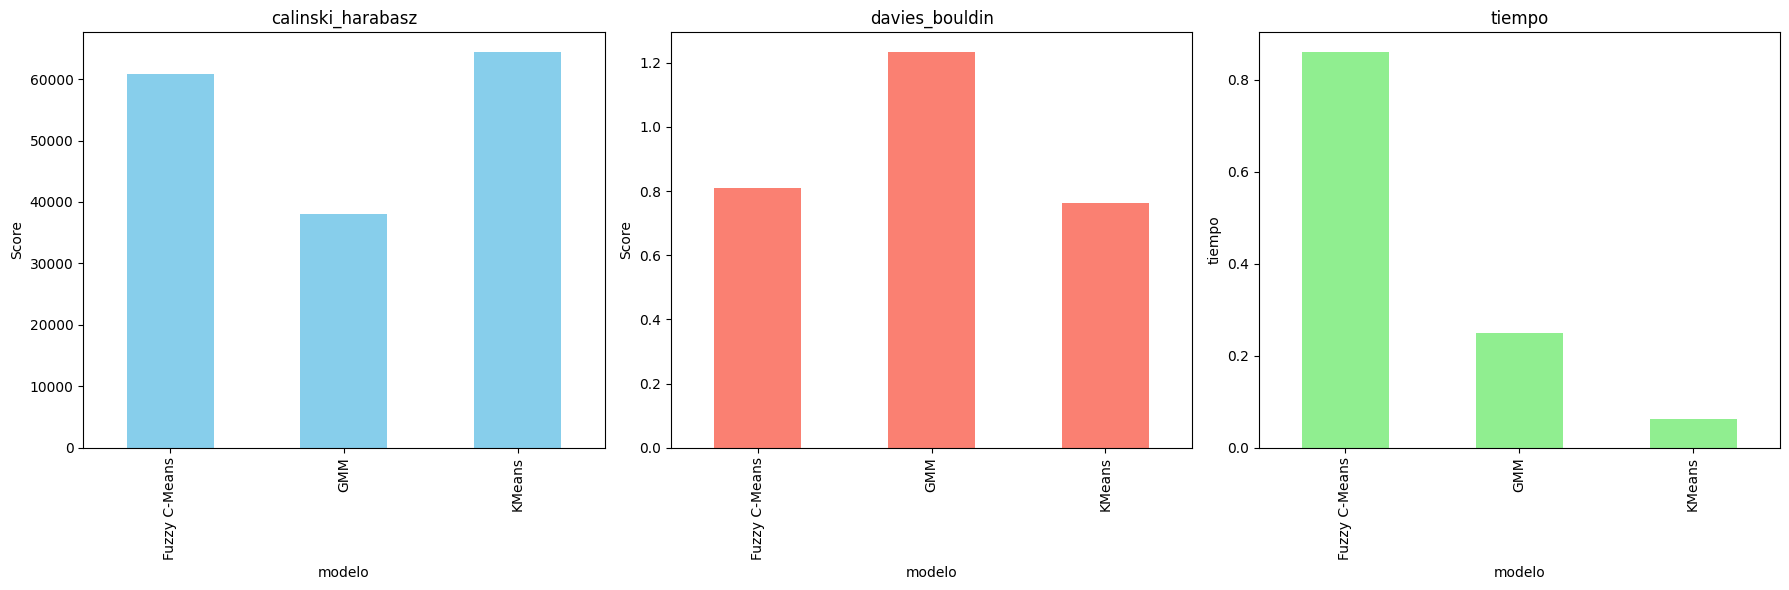

In [11]:
grouped_data = resultados_modelos.groupby('modelo').agg({'calinski_harabasz': 'mean', 'davies_bouldin': 'mean', 'tiempo': 'mean'})

# Comparación de los modelos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Calinski-Harabasz plot
grouped_data['calinski_harabasz'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('calinski_harabasz')
axes[0].set_ylabel('Score')

# Davies-Bouldin plot
grouped_data['davies_bouldin'].plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('davies_bouldin')
axes[1].set_ylabel('Score')

# Tiempo plot
grouped_data['tiempo'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('tiempo')
axes[2].set_ylabel('tiempo')

plt.tight_layout()
plt.show()

El análisis cuantitativo de los modelos de clustering revela que tanto K-Means como Fuzzy C-Means se destacan en términos de las métricas de Calinski-Harabasz y Davies-Bouldin. Estas métricas, cuando se combinan, ofrecen una visión holística del rendimiento de un algoritmo de clustering. El coeficiente de Calinski-Harabasz se maximiza cuando los clusters son densos y bien separados, lo cual es deseable en la segmentación de imágenes para obtener colores distintos. Por otro lado, el coeficiente de Davies-Bouldin se minimiza cuando los clusters están alejados y menos dispersos, lo cual sugiere una clara distinción entre los colores identificados.

La métrica de tiempo añade otra dimensión al análisis. No solo es importante que un algoritmo segmente bien las imágenes, sino que también debe hacerlo de manera eficiente. En este sentido, K-Means sobresale, equilibrando una buena segmentación con un rendimiento de tiempo superior. Esto indica que K-Means es capaz de proporcionar resultados de alta calidad en una fracción del tiempo que toma Fuzzy C-Means y GMM, haciéndolo ideal para aplicaciones en tiempo real o cuando se trabaja con grandes conjuntos de datos.

### Selección del mejor Modelo

En base a los resultados obtenidos, K-Means emerge como el mejor modelo para nuestra aplicación en la identificación de paletas de colores en imágenes artísticas. A pesar de su simplicidad, K-Means es efectivo, escalable y computacionalmente menos demandante que sus contrapartes, lo que lo hace particularmente atractivo para el procesamiento de grandes volúmenes de datos. Además, su facilidad de implementación y la claridad de los resultados facilitan su interpretación y ajuste.

### Consideraciones Adicionales

Cabe destacar que, aunque hemos elegido K-Means como el modelo preferido, esto no desmerece el valor de Fuzzy C-Means o GMM en otros contextos donde la interpretación probabilística de los datos o la capacidad de manejar la ambigüedad en la membresía de los clusters pueda ser más crucial. Por ejemplo, en escenarios donde los colores se superponen significativamente o cuando las transiciones de color son graduales y menos definidas, un enfoque más suave como el de Fuzzy C-Means podría ser más adecuado.


### Estimación de hiperparámetros

Dado el objetivo de este proyecto, es desarrollar un método automatizado para generar paletas de colores a partir de imágenes utilizando técnicas de machine learning no supervisado. Hay que hacer la optimización manual de hiperparámetros  dado que GridSearchCV no se adapta bien a este tipo de tarea donde cada "dato" es una imagen completa y no se cuenta con un valor verdadero de grupo para cada pixel.

Para optimizar los hiperparámetros del modelo seleccionado (K-means) GridSearchCV espera que los datos estén en un formato que pueda ser procesado uniformemente en lotes, lo cual es desafiante cuando trabajamos con imágenes que requieren preprocesamiento individualizado.

**K-Means**

A continuación, se definie una función de búsqueda y evaluación que, dada una imagen y nuestro pipeline (adicionalmente un parámetro por si se desea ver la tabla de resultados), ejecuta las combinaciones de hiperparámetros, evalúa según las métricas definidas, y retorna la mejor combinación de hiperparámetros encontrada.


In [12]:
pipeline = Pipeline([
    ('preprocesar_imagen', FunctionTransformer(preprocesar_imagen)), # Paso de preprocesamiento con función definida
    ('cluster', KMeans()) # Modelo base
])


image_readed = cv2.imread(images_list[10])

def buscar_hiperparams_kmeans(image_readed, pipeline, show_table=False):

    # lista de parámetros
    combinations = list(
        product(
            [5, 6, 7], # n_clusters
            ['k-means++', 'random'], # init
            [47] # random_state
        )) 


    resultados = []

    for parametros in combinations:

        pipeline.set_params(cluster__n_clusters=parametros[0], cluster__init=parametros[1], cluster__random_state=parametros[2])
        pipeline.fit(image_readed)
        labels = pipeline.named_steps['cluster'].labels_
        # Calcular métricas
        inertia = pipeline.named_steps['cluster'].inertia_
        calinski_harabasz = calinski_harabasz_score(pipeline.named_steps["preprocesar_imagen"].transform(image_readed), labels)
        davies_bouldin = davies_bouldin_score(pipeline.named_steps["preprocesar_imagen"].transform(image_readed), labels)

        resultados.append((parametros, inertia, calinski_harabasz, davies_bouldin))

    resultados = pd.DataFrame(resultados, columns=["parametros", "inertia", "calinski_harabasz", "davies_bouldin"])
    resultados.sort_values("calinski_harabasz", ascending=False)

    display(resultados) if show_table else None

    return resultados.loc[0, "parametros"]


n_clusters,init,random_state = buscar_hiperparams_kmeans(image_readed, pipeline,show_table=True)

print(f"Mejores hiperparámetros: n_clusters={n_clusters}, init={init}, random_state={random_state}")

parametros     inertia  calinski_harabasz  davies_bouldin
0  (5, k-means++, 47)  157.930462       21658.502808        0.765097
1     (5, random, 47)  157.928250       21658.731165        0.765051
2  (6, k-means++, 47)  134.853092       20851.640112        0.832730
3     (6, random, 47)  133.200809       21150.304763        0.788440
4  (7, k-means++, 47)  113.686364       21118.182481        0.845400
5     (7, random, 47)  111.941922       21489.985035        0.822845

Mejores hiperparámetros: n_clusters=5, init=k-means++, random_state=47


<a id='aplicacion_modelo'></a>
# Aplicación del modelo K-Means a Imágenes Individuales

Por último, se aplica procesan 10 imágenes aleatorias en las cuales:
* Se visualiza la imagen original.
* Realiza búsqueda de los mejores hiperparámetros que se pasarán al pipeline del modelo seleccionado (K-means).
* Genera la paleta de colores a partir de la imagen.
* Se procesan los resultados y se visualiza en 2D la distribución de colores en la paleta generada.

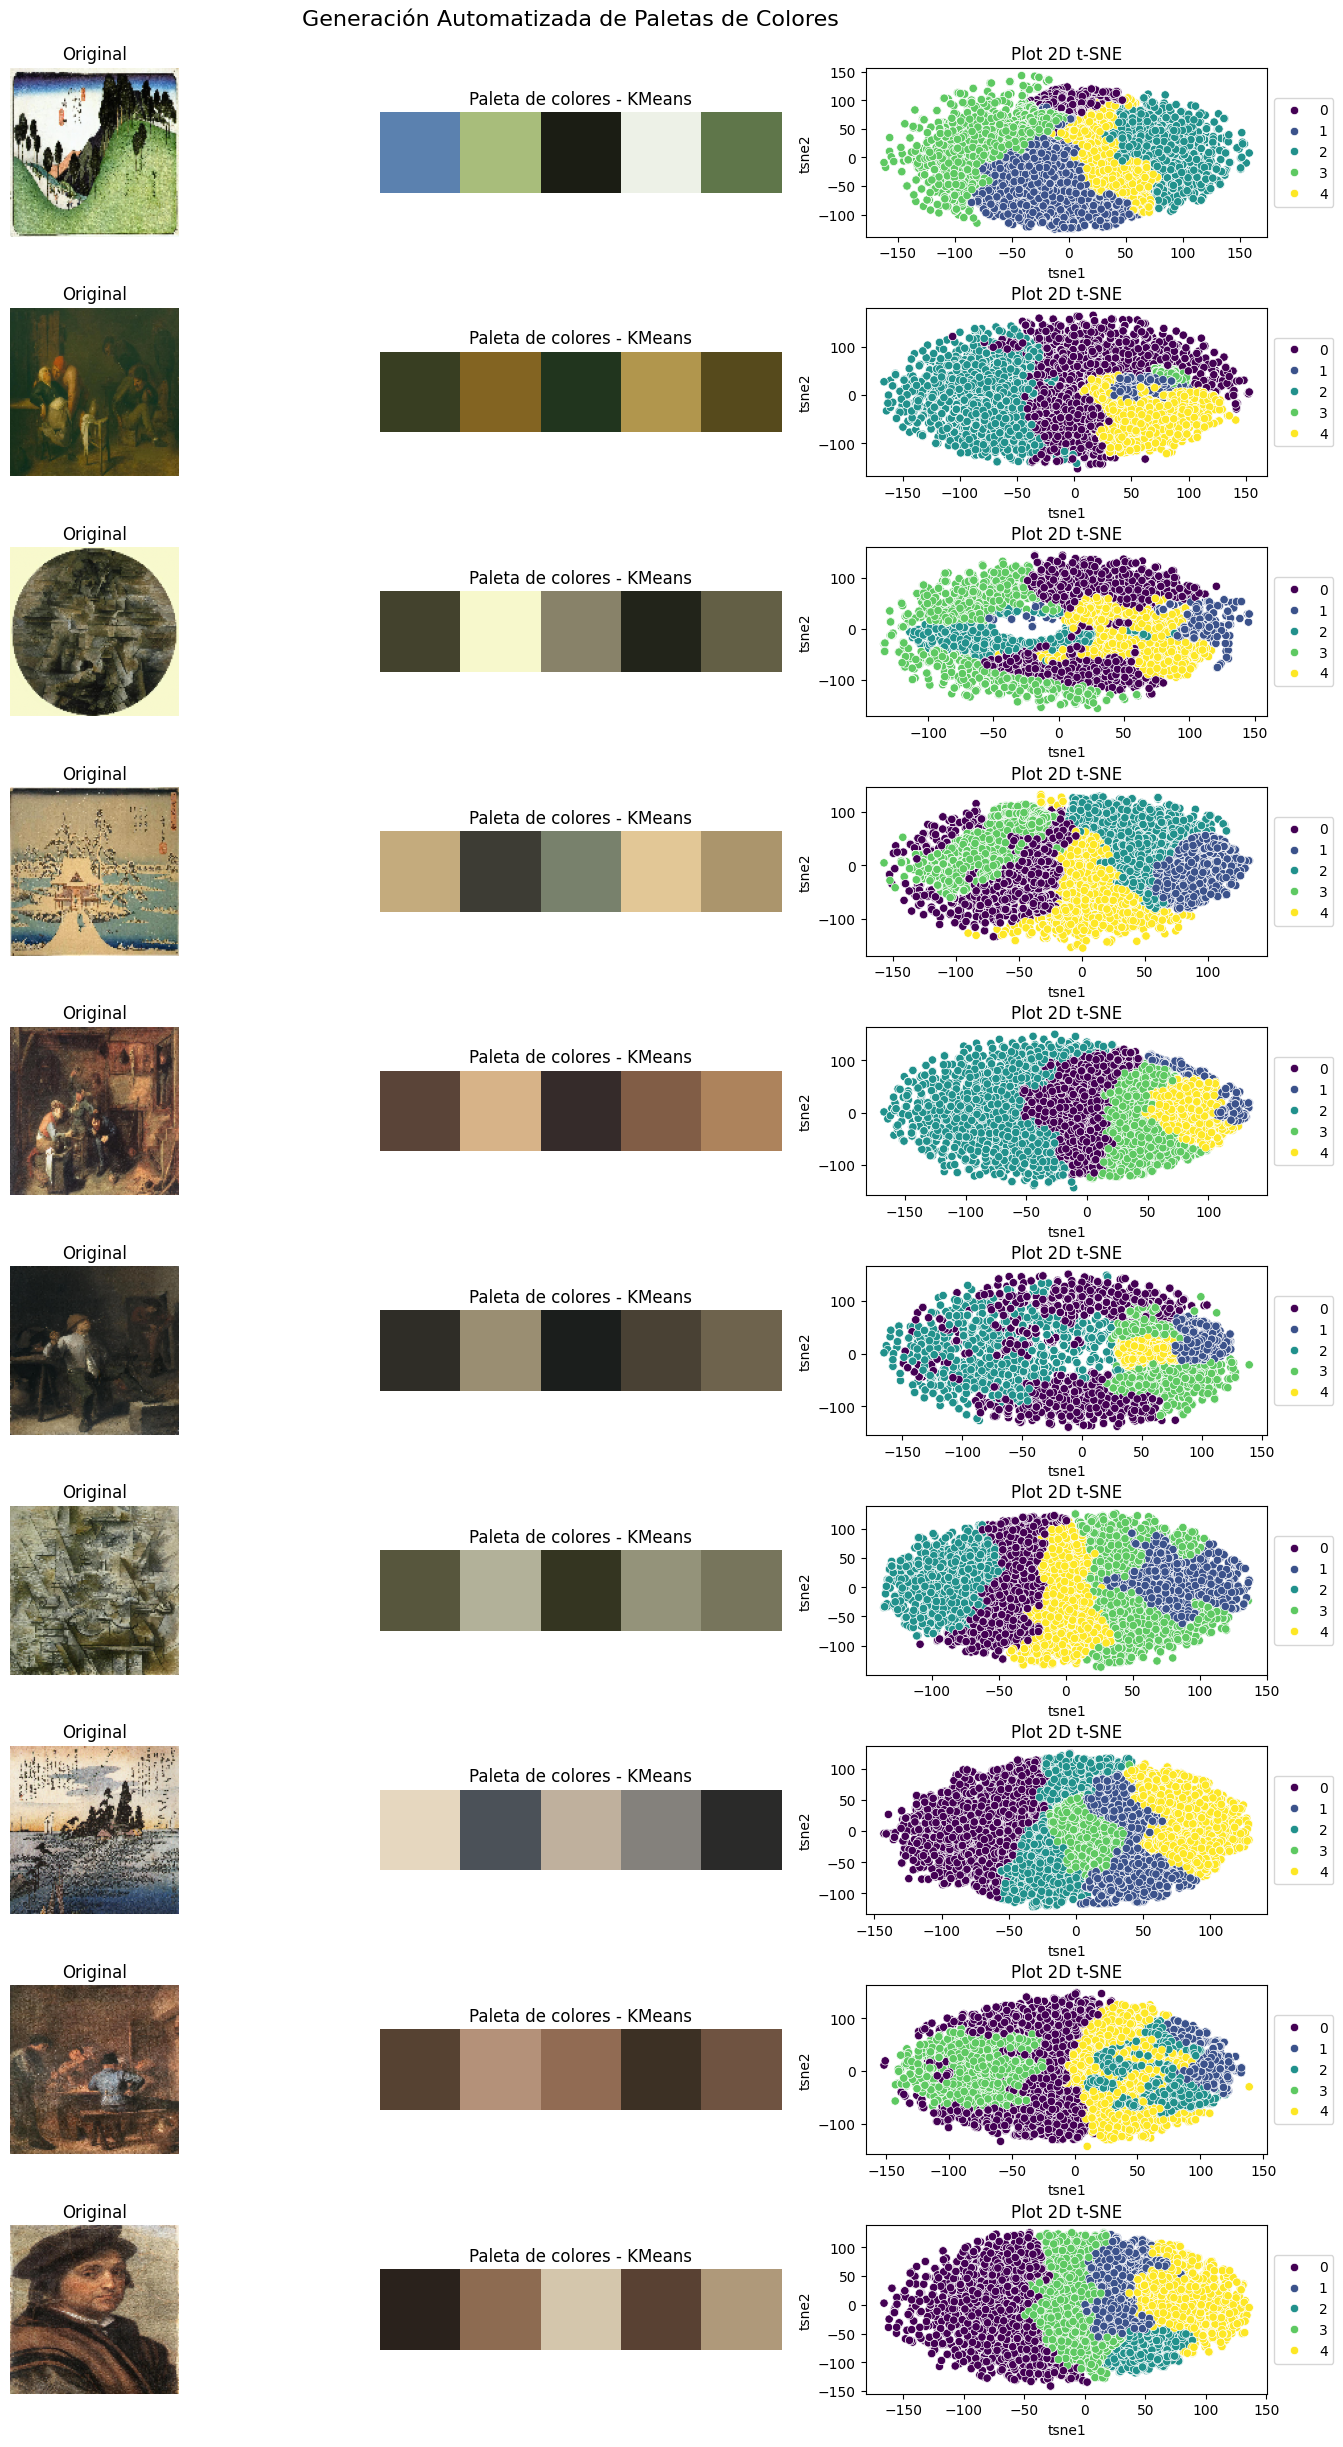

In [13]:
# Seleccionar 10 imágenes aleatorias para aplicar el modelo
test_images = random.sample(images_list, 10)


def plot_palette(ax,cluster_centers):

    cluster_centers = cluster_centers * 255
    cluster_centers = cluster_centers.astype(np.uint8)
    ax.imshow([cluster_centers])
    ax.set_title('Paleta de colores - KMeans')
    ax.axis('off')
    # Adjust margins to remove blank space
    ax.margins(0)
    

fig, axs = plt.subplots(len(test_images), 3, figsize=(15, 25))
fig.suptitle('Generación Automatizada de Paletas de Colores', fontsize=16)
plt.tight_layout(pad=3.0)


for i, image in enumerate(test_images):

    image_readed = cv2.imread(image)
    # dato transformado
    X = pipeline.named_steps['preprocesar_imagen'].transform(image_readed)
    
    # Original
    plot_original_image(axs[i, 0], image_readed)

    # KMeans
    n_clusters,init,random_state = buscar_hiperparams_kmeans(image_readed, pipeline,show_table=False)

    pipeline.set_params(cluster__n_clusters=n_clusters, cluster__init=init, cluster__random_state=random_state)

    pipeline.fit(image_readed)

    labels = pipeline.named_steps['cluster'].labels_
    cluster_centers = pipeline.named_steps['cluster'].cluster_centers_

    plot_palette(axs[i, 1], cluster_centers)



    # reducción de dimensionalidad con pca y t-sne
    pca = PCA(n_components=2)
    # perplexity bajo para capturar la estructura local, por ende se consideran menos vecinos para el cálculo de la distribución de probabilidad (5 a 15)
    tsne = TSNE(n_components=2, random_state=42, perplexity=5,n_iter=1000)

    # Ajustar y transformar
    pca_result = pca.fit_transform(X)
    tsne_result = tsne.fit_transform(pca_result)

    # Crear un DataFrame con los resultados
    df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])
    df['label'] = labels
    # Plot 2D t-SNE
    sns.scatterplot(data=df, x='tsne1', y='tsne2', hue=labels, palette="viridis",ax=axs[i, 2])
    axs[i, 2].set_title('Plot 2D t-SNE')
    axs[i, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)



# **Conclusiones del Proyecto.**


* Este proyecto alcanzó su meta de crear un método automatizado para generar paletas de colores a partir de imágenes mediante machine learning no supervisado, enfocándose en K-Means. 
* La fase de exploración y el preprocesamiento meticuloso de las imágenes aseguraron datos de entrada uniformes, mejorando el rendimiento del modelo. 
* La selección de K-Means, junto con una búsqueda de hiperparámetros, permitió adaptar el modelo a las necesidades específicas de cada imagen, logrando una segmentación de color precisa. Este enfoque meticuloso subraya la importancia de un ajuste fino para obtener resultados de alta calidad, demostrando la eficacia de K-Means en la generación de paletas cohesivas y visualmente atractivas, contribuyendo significativamente al análisis de imágenes y diseño.